In [1]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
from torchvision.models import resnet18
model = resnet18(weights=None)
model.fc = torch.nn.Linear(512,10)
model.load_state_dict(torch.load("model.pth"))
model.eval();

In [5]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

from alibi_detect.cd import MMDDrift
from alibi_detect.cd.pytorch import preprocess_drift

from torchvision.datasets import CIFAR10

from torch.utils.data.dataloader import DataLoader

import torchvision.transforms as T

torch.manual_seed(42)

In [6]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)

test_transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )

In [7]:
cifar10_test_ds = CIFAR10("./data/", train=False, download=True, transform=test_transform)
test_ref, test_ref_h0 = torch.utils.data.random_split(cifar10_test_ds, (5_000, 5_000), )
test_ref_data, test_ref_data_h0 = next(iter(DataLoader(test_ref, batch_size=5_000, shuffle=False))), next(iter(DataLoader(test_ref_h0, batch_size=5_000, shuffle=False)))
test_ref_data[0].shape, test_ref_data[1].shape

Using downloaded and verified file: ./data/cifar-10-python.tar.gz
Extracting ./data/cifar-10-python.tar.gz to ./data/


(torch.Size([5000, 3, 32, 32]), torch.Size([5000]))

In [8]:
preprocess_fn = partial(preprocess_drift, model=model, device=device, batch_size=512)

In [9]:
cd = MMDDrift(test_ref_data[0], backend='pytorch', p_val=.05, preprocess_fn=preprocess_fn, n_permutations=100)

No GPU detected, fall back on CPU.


In [10]:
import albumentations as A
import matplotlib.pyplot as plt

## Classiying Original Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


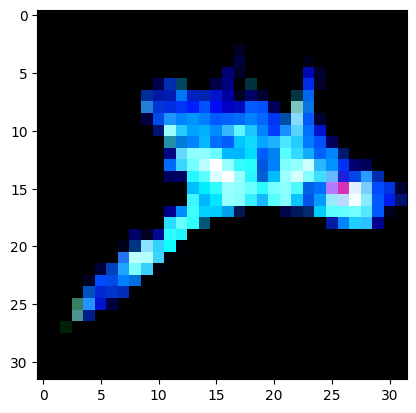

In [11]:
plt.imshow(
    torch.tensor(test_ref_data_h0[0][10].numpy()).permute(1, 2, 0)
)
plt.show()

In [12]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [13]:
torch.argmax(model(test_ref_data_h0[0][10][None, ...].to(device)), dim=-1)

tensor([0])

In [14]:
classes[0]

'plane'

## Classifying Perturbed Image

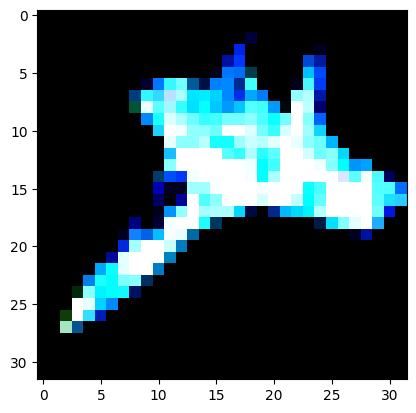

In [16]:
perturb = A.RandomBrightnessContrast(
    brightness_limit=1.5,
    contrast_limit=0.9,
    p=1.0
)

perturbed_image = torch.tensor(
    perturb(
        image=test_ref_data_h0[0][10].numpy(),
    )['image']
)

plt.imshow(
    perturbed_image.permute(1, 2, 0)
)
plt.show()

In [17]:
torch.argmax(model(perturbed_image[None, ...].to(device)), dim=-1)

tensor([0])

In [18]:
classes[0]

'plane'

The prediction has remained unchanged since our model was trained using rigorous augmentations. This is unlike what we saw in the session, where perturbation yielded an incorrect result. 

DD on the entire **un-perturbed** dataset 

In [19]:
cd.predict(test_ref_data_h0[0][:100])

{'data': {'is_drift': 0,
  'distance': -0.00016295909881591797,
  'p_val': 0.4399999976158142,
  'threshold': 0.05,
  'distance_threshold': array(0.00382191, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'online': False,
  'data_type': None,
  'version': '0.10.4',
  'detector_type': 'drift',
  'backend': 'pytorch'}}

DD on entire **perturbed** data

In [20]:
perturbed_images = []

for idx in range(100):
    perturbed_image = torch.tensor(
        perturb(
            image=test_ref_data_h0[0][idx].numpy(),
        )['image']
    )

    perturbed_images.append(perturbed_image)

perturbed_images = torch.stack(perturbed_images)

cd.predict(perturbed_images[:100])

{'data': {'is_drift': 1,
  'distance': 0.15907317399978638,
  'p_val': 0.0,
  'threshold': 0.05,
  'distance_threshold': array(0.00352854, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'online': False,
  'data_type': None,
  'version': '0.10.4',
  'detector_type': 'drift',
  'backend': 'pytorch'}}

Overall, we see that it has detected a data-drift.